This is the detection model

## Imports

In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from sklearn.model_selection import train_test_split

import os
import random
import shutil

import kagglehub

from PIL import Image,ImageEnhance
import random
import warnings
warnings.filterwarnings("ignore")

# Detection Model (Pytorch Refactor)

NOTE: Now updated w. new dataset

## Data Augmentation

In [ ]:
os.makedirs("kaggle/working/data-augmentation/detection", exist_ok=True)
os.makedirs('kaggle/working/data-augmentation/classification/notumor', exist_ok=True)
os.makedirs('kaggle/working/data-augmentation/classification/glioma', exist_ok=True)
os.makedirs('kaggle/working/data-augmentation/classification/meningioma', exist_ok=True)
os.makedirs('kaggle/working/data-augmentation/classification/pituitary', exist_ok=True)


#randomly changes Image
def apply_augmentation(image):

    angle=random.randint(-20,20)
    augmented_image=image.rotate(angle)

    if(random.random()>0.5):
        augmented_image=augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    brightness_factor=random.uniform(0.85,1.15)
    enhanced_image= ImageEnhance.Brightness(augmented_image).enhance(brightness_factor)

    contrast_factor = random.uniform(0.85, 1.15)
    enhanced_image = ImageEnhance.Contrast(enhanced_image).enhance(contrast_factor)

    color_image = ImageEnhance.Color(enhanced_image).enhance(random.uniform(0.8, 1.2))

    scale_factor=random.uniform(0.8,1.2)
    new_size=(int(color_image.width * scale_factor),int(color_image.height * scale_factor))

    new_image=color_image.resize(new_size,Image.NEAREST)

    return new_image


def data_augmentation_detection_model(input_dir, output_dir, image_num_no=5, image_num_yes=8):
  for folder in os.listdir(input_dir):
        folder_path = os.path.join(input_dir, folder)

        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".png", ".jpeg")):
                    input_path = os.path.join(folder_path, file)
                    image = Image.open(input_path).convert("L")

                    if folder == "no-tumor":
                        output_folder = os.path.join(output_dir, "notumor")
                        os.makedirs(output_folder, exist_ok=True)
                        for i in range(image_num_no):
                            augmented_image = apply_augmentation(image)
                            output_file = f"{os.path.splitext(file)[0]}_{i}.png"
                            output_path = os.path.join(output_folder, output_file)
                            augmented_image.save(output_path)

                    if folder == "glioma":  #for glioma imgs
                        output_folder = os.path.join(output_dir, folder)
                        os.makedirs(output_folder, exist_ok=True)
                        for i in range(image_num_yes):
                            augmented_image = apply_augmentation(image)
                            output_file = f"{os.path.splitext(file)[0]}_{i}.png"
                            output_path = os.path.join(output_folder, output_file)
                            augmented_image.save(output_path)

                    elif folder == "meningioma": #for meninglioma imgs
                        output_folder = os.path.join(output_dir, folder)
                        os.makedirs(output_folder, exist_ok=True)
                        for i in range(image_num_yes):
                            augmented_image = apply_augmentation(image)
                            output_file = f"{os.path.splitext(file)[0]}_{i}.png"
                            output_path = os.path.join(output_folder, output_file)
                            augmented_image.save(output_path)

                    elif folder == "pituitary": #for pituitary imgs
                        output_folder = os.path.join(output_dir, folder)
                        os.makedirs(output_folder, exist_ok=True)
                        for i in range(image_num_yes):
                            augmented_image = apply_augmentation(image)
                            output_file = f"{os.path.splitext(file)[0]}_{i}.png"
                            output_path = os.path.join(output_folder, output_file)
                            augmented_image.save(output_path)

In [ ]:
# Download dataset and augment

path = kagglehub.dataset_download("mohamada2274/brain-tumor-mri")

# NOTE: Add \Brian\Training to the path (kaggle dataset has typo: Brain -> Brian)
path = os.path.join(path, "Brian", "Training")

print(path)

input_dir=path
output_dir="kaggle/working/data-augmentation/detection/"

# NOTE: changed num augmented images from x5 -> x1 since new dataset is large enough
data_augmentation_detection_model(input_dir=input_dir,output_dir=output_dir,image_num_no=1,image_num_yes=1)

print("Number of photos named 'yes' :",len(listdir("kaggle/working/data-augmentation/detection/glioma"))+len(listdir("kaggle/working/data-augmentation/detection/meningioma"))+len(listdir("kaggle/working/data-augmentation/detection/pituitary")))
print("Number of photos named 'no' :",len(listdir("kaggle/working/data-augmentation/detection/notumor")))

100%|██████████| 426M/426M [00:04<00:00, 90.5MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/mohamada2274/brain-tumor-mri/versions/1/Brian/Training
Number of photos named 'yes' : 24493
Number of photos named 'no' : 5588


In [ ]:
def delete_images(directory):
    counter = 0
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):
          counter = counter+1
          if(counter>1861):
            os.remove(file_path)

directory_to_clean = "kaggle/working/data-augmentation/detection/glioma"
delete_images(directory_to_clean)
directory_to_clean = "kaggle/working/data-augmentation/detection/meningioma"
delete_images(directory_to_clean)
directory_to_clean = "kaggle/working/data-augmentation/detection/pituitary"
delete_images(directory_to_clean)


print(len(listdir("kaggle/working/data-augmentation/detection/glioma")))
print(len(listdir("kaggle/working/data-augmentation/detection/meningioma")))
print(len(listdir("kaggle/working/data-augmentation/detection/pituitary")))

1861
1861
1861


## Load Data

In [ ]:
class CustomDataset(Dataset):

    def __init__(self,root_dir,transform=None):
        self.root_dir=root_dir
        self.transform=transform

        self.images=[]
        self.labels=[]

        for subdir,_,files in os.walk(root_dir):
            for file in files:
                if(file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg")):
                    self.images.append(os.path.join(subdir,file))

                    label = 1 if "glioma" in subdir else 2 if "meningioma" in subdir else 3 if "pituitary" in subdir else 0

                    self.labels.append(label)


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image_path=self.images[idx]
        image=Image.open(image_path).convert("L")

        if(self.transform):
            image=self.transform(image)

        label=self.labels[idx]

        return image,label


transform=transforms.Compose([transforms.Resize((240,240)),
                              transforms.ToTensor(),
                               transforms.Normalize([0.485],[0.229])
                              ])

root_dir="kaggle/working/data-augmentation/detection/"
train_test_dataset=CustomDataset(root_dir=root_dir,transform=transform)


train_size=0.7
test_size=0.15
valid_size=1-(train_size+test_size)

total_data=len(train_test_dataset)
indices=list(range(total_data))

train_indices, test_indices = train_test_split(indices, test_size=(test_size + valid_size),random_state=42)
test_indices, valid_indices = train_test_split(test_indices, test_size=(valid_size / (test_size + valid_size)),random_state=42)

print(" Number of train indices:{}\n Number of test indices:{}\n Number of validation indices:{}".format(len(train_indices),len(test_indices),len(valid_indices)))

train_dataset=torch.utils.data.Subset(train_test_dataset,train_indices)
test_dataset=torch.utils.data.Subset(train_test_dataset,test_indices)
valid_dataset=torch.utils.data.Subset(train_test_dataset,valid_indices)

batch_size = 64

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size)

 Number of train indices:7819
 Number of test indices:1676
 Number of validation indices:1676


## Visualize Dataset

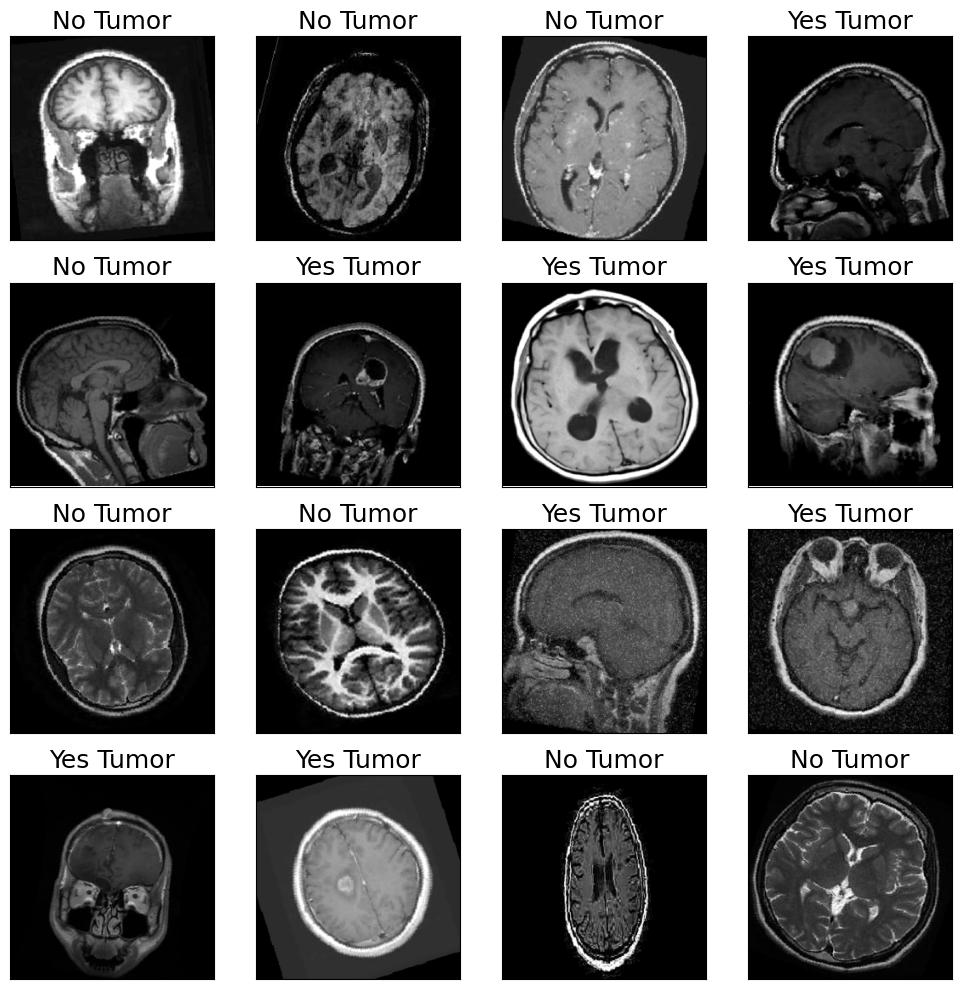

In [ ]:
# Visualize Data

data_iter=iter(train_loader)
images,labels=next(data_iter)

images=images.numpy()

iteration=16

fig=plt.figure(figsize=(10,10))

for index in np.arange(iteration):

    ax=fig.add_subplot(4,int(iteration/4),index+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[index]),cmap="gray")
    ax.set_title("No Tumor" if str(labels[index])[-2]=="0" else "Yes Tumor",fontsize=18)


plt.tight_layout()

## VGG-16 Architecture

In [ ]:
class VGG16(nn.Module):

    def __init__(self,num_classes=1000):
        super(VGG16,self).__init__()

        #feature extractor
        self.features=nn.Sequential(
            #grayscale image -> 64 feature maps
            nn.Conv2d(1,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #64 feature maps -> 128
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #128 -> 256
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #256 -> 512
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #512 -> 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )

        #resizes self.features into 7x7
        self.avgpool=nn.AdaptiveAvgPool2d((7,7))

        #extracts features
        self.classifier=nn.Sequential(nn.Linear(512*7*7,4096),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(),
                                     nn.Linear(4096,4096),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(4096,num_classes)
                                     )

        self._initialize_weights()


    def forward(self,x):
        x=self.features(x)          # Feature extraction
        x=self.avgpool(x)           # Resize to (7, 7)
        x = x.view(x.size(0), -1)   # Flatten to a vector
        x=self.classifier(x)        # Fully connected layers

        return x


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

## Train Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

vgg16_kaiming = VGG16(num_classes=2).to(device)

epochs = 40
learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(vgg16_kaiming.parameters(), lr=learning_rate)

def train(model,train_loader,optimizer,criteron):
    model.train()
    train_loss=0
    correct=0
    total=0

    for images,labels in train_loader:
        #convert labels to binary
        labels = torch.clamp(labels, max=1)

        images,labels =images.to(device),labels.to(device)

        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)

        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        _,predicted=outputs.max(1)
        total+=labels.size(0)
        correct+=predicted.eq(labels).sum().item()

    train_accuracy=100*correct/total
    train_loss/=len(train_loader)
    return train_loss,train_accuracy

def validate(model,valid_loader,criterion):
    model.eval()
    val_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for images,labels in valid_loader:
            #convert labels to binary
            labels = torch.clamp(labels, max=1)

            images,labels=images.to(device),labels.to(device)

            outputs=model(images)
            loss=criterion(outputs,labels)

            val_loss+=loss.item()
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()

        val_accuracy = 100.0 * correct / total
        val_loss /= len(valid_loader)
    return val_loss, val_accuracy

cuda:0


In [ ]:
train_accuracy = []
validation_accuracy = []
train_losses = []
validation_losses = []

patience = 5                  # Number of epochs to wait before stopping
best_val_loss = float('inf')  # Initialize with infinity
counter = 0                   # Counter for how many epochs since last improvement

for epoch in range(epochs):
    train_loss, train_acc = train(vgg16_kaiming, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(vgg16_kaiming, valid_loader, criterion)

    train_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset the counter when improvement occurs
    else:
        counter += 1
        print(f"Early stopping counter: {counter}/{patience}")

        if counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

Epoch 1/40: Train Loss: 0.5177, Validation Loss: 0.4551 Train Accuracy: 74.22%, Validation Accuracy: 80.13%
Epoch 2/40: Train Loss: 0.3155, Validation Loss: 0.3003 Train Accuracy: 87.13%, Validation Accuracy: 87.53%
Epoch 3/40: Train Loss: 0.2149, Validation Loss: 0.2857 Train Accuracy: 92.29%, Validation Accuracy: 88.90%
Epoch 4/40: Train Loss: 0.1707, Validation Loss: 0.2100 Train Accuracy: 93.96%, Validation Accuracy: 92.30%
Epoch 5/40: Train Loss: 0.1301, Validation Loss: 0.1479 Train Accuracy: 95.46%, Validation Accuracy: 94.21%
Epoch 6/40: Train Loss: 0.1089, Validation Loss: 0.2050 Train Accuracy: 96.36%, Validation Accuracy: 93.20%
Early stopping counter: 1/5
Epoch 7/40: Train Loss: 0.0823, Validation Loss: 0.1141 Train Accuracy: 97.01%, Validation Accuracy: 95.94%
Epoch 8/40: Train Loss: 0.0622, Validation Loss: 0.1473 Train Accuracy: 97.95%, Validation Accuracy: 95.58%
Early stopping counter: 1/5
Epoch 9/40: Train Loss: 0.0517, Validation Loss: 0.1783 Train Accuracy: 98.11%, 

## Training Results

Accuracy

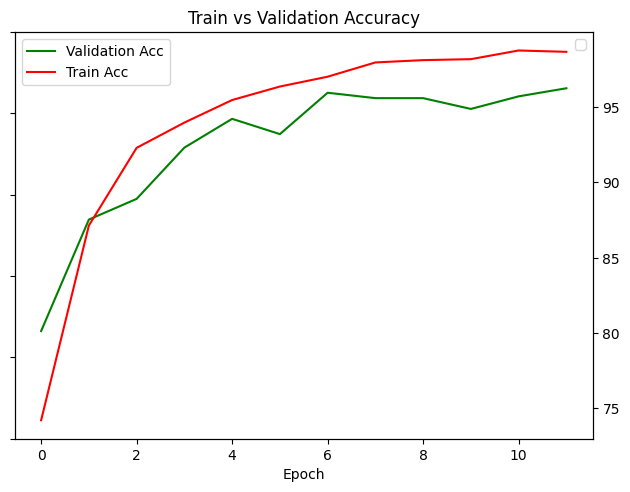

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(np.array(validation_accuracy),label = "Validation Acc",color="green")
ax2.plot(np.array(train_accuracy),label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])
fig.tight_layout()
plt.title("Train vs Validation Accuracy")
plt.show()

Loss

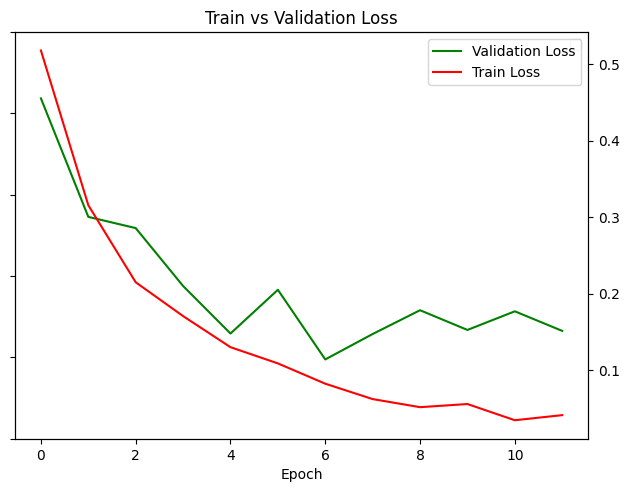

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(np.array(validation_losses),label = "Validation Loss",color="green")
ax2.plot(np.array(train_losses),label = "Train Loss",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])
fig.tight_layout()
plt.title("Train vs Validation Loss")
plt.show()

Testing Predictions

In [ ]:
predictions=[]
actual_labels=[]

tumor_detected_imgs=[]
tumor_detected_labels=[]

vgg16_kaiming.eval()

with torch.no_grad():
    for images,labels in test_loader:
        #raw labels
        raw_labels=labels.clone()

        #convert labels to binary
        clamped_labels = torch.clamp(labels, max=1)

        images = images.to(device)
        raw_labels = raw_labels.to(device)
        clamped_labels = clamped_labels.to(device)

        outputs=vgg16_kaiming(images)
        _,predicted=torch.max(outputs,1)

        #saved for classification
        tumor_detected= (clamped_labels == 1).cpu()
        tumor_detected_imgs.append(images[tumor_detected])
        tumor_detected_labels.append(raw_labels[tumor_detected])

        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(clamped_labels.cpu().numpy())

tumor_detected_imgs = torch.cat(tumor_detected_imgs)
tumor_detected_labels = torch.cat(tumor_detected_labels)
tumor_detected_dataset= TensorDataset(tumor_detected_imgs,tumor_detected_labels)
tumor_detected_loader=DataLoader(tumor_detected_dataset, batch_size=64)

results_df=pd.DataFrame({"Actual":actual_labels,"Predicted":predictions})
results_df

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
1671,0,0
1672,0,0
1673,1,1
1674,0,0


In [ ]:
from sklearn.metrics import accuracy_score

true_labels=results_df["Actual"]
#convert labels to binary
labels = torch.clamp(labels, max=1)
predicted_labels=results_df["Predicted"]

accuracy=accuracy_score(true_labels,predicted_labels)

correct_predictions = (true_labels == predicted_labels).sum()
print(f"Total number of correct predictions: {correct_predictions}")
print(f"Accuracy Score:% {accuracy*100}")

Total number of correct predictions: 1614
Accuracy Score:% 96.30071599045345


Confusion Matrix/Classification Report

<Axes: >

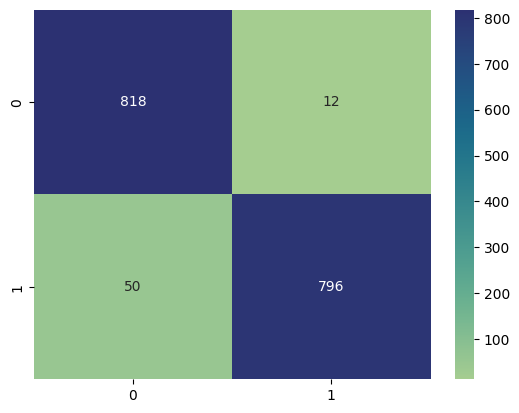

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

confusionMatrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusionMatrix, annot=True, cmap='crest', fmt='g')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       830
           1       0.98      0.93      0.96       846

    accuracy                           0.96      1676
   macro avg       0.96      0.96      0.96      1676
weighted avg       0.96      0.96      0.96      1676



# Classification Model

##augment data

In [ ]:
os.makedirs("kaggle/working/data-augmentation/classification", exist_ok=True)
os.makedirs('kaggle/working/data-augmentation/classification/glioma', exist_ok=True)
os.makedirs('kaggle/working/data-augmentation/classification/meningioma', exist_ok=True)
os.makedirs('kaggle/working/data-augmentation/classification/pituitary', exist_ok=True)
os.makedirs('kaggle/working/data-augmentation/classification/notumor', exist_ok=True)

#randomly changes Image
def apply_augmentation(image):

    angle=random.randint(-20,20)
    augmented_image=image.rotate(angle)

    if(random.random()>0.5):
        augmented_image=augmented_image.transpose(Image.FLIP_LEFT_RIGHT)

    brightness_factor=random.uniform(0.85,1.15)
    enhanced_image= ImageEnhance.Brightness(augmented_image).enhance(brightness_factor)

    contrast_factor = random.uniform(0.85, 1.15)
    enhanced_image = ImageEnhance.Contrast(enhanced_image).enhance(contrast_factor)

    color_image = ImageEnhance.Color(enhanced_image).enhance(random.uniform(0.8, 1.2))

    scale_factor=random.uniform(0.8,1.2)
    new_size=(int(color_image.width * scale_factor),int(color_image.height * scale_factor))

    new_image=color_image.resize(new_size,Image.NEAREST)

    return new_image

def data_augmentation_classification_model(input_dir, output_dir, img_num_glioma=5, img_num_minin=8, img_num_pituitary=5):
    for folder in os.listdir(input_dir):
        folder_path = os.path.join(input_dir, folder)

        if os.path.isdir(folder_path) and not folder_path.endswith('notumor'):  #excludes notumor
            for file in os.listdir(folder_path):
                if file.endswith((".jpg", ".png", ".jpeg")):
                    input_path = os.path.join(folder_path, file)
                    image = Image.open(input_path).convert("L")

                    if folder == "glioma":  #for glioma imgs
                        output_folder = os.path.join(output_dir, folder)
                        os.makedirs(output_folder, exist_ok=True)
                        for i in range(img_num_glioma):
                            augmented_image = apply_augmentation(image)
                            output_file = f"{os.path.splitext(file)[0]}_{i}.png"
                            output_path = os.path.join(output_folder, output_file)
                            augmented_image.save(output_path)

                    elif folder == "meningioma": #for meninglioma imgs
                        output_folder = os.path.join(output_dir, folder)
                        os.makedirs(output_folder, exist_ok=True)
                        for i in range(img_num_minin):
                            augmented_image = apply_augmentation(image)
                            output_file = f"{os.path.splitext(file)[0]}_{i}.png"
                            output_path = os.path.join(output_folder, output_file)
                            augmented_image.save(output_path)

                    elif folder == "pituitary": #for pituitary imgs
                        output_folder = os.path.join(output_dir, folder)
                        os.makedirs(output_folder, exist_ok=True)
                        for i in range(img_num_pituitary):
                            augmented_image = apply_augmentation(image)
                            output_file = f"{os.path.splitext(file)[0]}_{i}.png"
                            output_path = os.path.join(output_folder, output_file)
                            augmented_image.save(output_path)

In [ ]:
# Download dataset and augment

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print(path)

#mixing testing and training together since we do our own separation
input_dir_testing= path + '/Testing'
input_dir_training= path + '/Training'
output_dir="kaggle/working/data-augmentation/classification/"

data_augmentation_classification_model(input_dir=input_dir_testing,output_dir=output_dir,img_num_glioma=1,img_num_minin=1,img_num_pituitary=1)
data_augmentation_classification_model(input_dir=input_dir_training,output_dir=output_dir,img_num_glioma=1,img_num_minin=1,img_num_pituitary=1)

print("Number of photos named 'glioma':",len(listdir("kaggle/working/data-augmentation/classification/glioma")))
print("Number of photos named 'menin':",len(listdir("kaggle/working/data-augmentation/classification/meningioma")))
print("Number of photos named 'pituitary':",len(listdir("kaggle/working/data-augmentation/classification/pituitary")))

100%|██████████| 149M/149M [00:00<00:00, 213MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1
Number of photos named 'glioma': 1621
Number of photos named 'menin': 1645
Number of photos named 'pituitary': 1757


##LoadData

In [ ]:
class CustomDataset(Dataset):

    def __init__(self,root_dir2,transform2=None):
        self.root_dir2=root_dir2
        self.transform2=transform2

        self.images=[]
        self.labels=[]

        for subdir,_,files in os.walk(root_dir2):
            for file in files:
                if(file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg")):
                    self.images.append(os.path.join(subdir,file))

                    label = 1 if "glioma" in subdir else 2 if "meningioma" in subdir else 3 if "pituitary" in subdir else 0

                    self.labels.append(label)


    def __len__(self):
        return len(self.images)

    def __getitem__(self,idx):
        image_path=self.images[idx]
        image=Image.open(image_path).convert("L")

        if(self.transform2):
            image=self.transform2(image)

        label=self.labels[idx]

        return image,label


transform2=transforms.Compose([transforms.Resize((240,240)),
                              transforms.ToTensor(),
                               transforms.Normalize([0.485],[0.229])
                              ])

root_dir2="kaggle/working/data-augmentation/classification"
train_test_dataset=CustomDataset(root_dir2=root_dir2,transform2=transform2)


train_size=0.7
test_size=0.15
valid_size=1-(train_size+test_size)

total_data=len(train_test_dataset)
indices=list(range(total_data))

train_indices, test_indices = train_test_split(indices, test_size=(test_size + valid_size),random_state=42)
test_indices, valid_indices = train_test_split(test_indices, test_size=(valid_size / (test_size + valid_size)),random_state=42)

print(" Number of train indices:{}\n Number of test indices:{}\n Number of validation indices:{}".format(len(train_indices),len(test_indices),len(valid_indices)))

train_dataset=torch.utils.data.Subset(train_test_dataset,train_indices)
test_dataset=torch.utils.data.Subset(train_test_dataset,test_indices)
valid_dataset=torch.utils.data.Subset(train_test_dataset,valid_indices)

batch_size = 64

train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=batch_size)
valid_loader=DataLoader(valid_dataset,batch_size=batch_size)

 Number of train indices:3516
 Number of test indices:753
 Number of validation indices:754


##Visualize Dataset

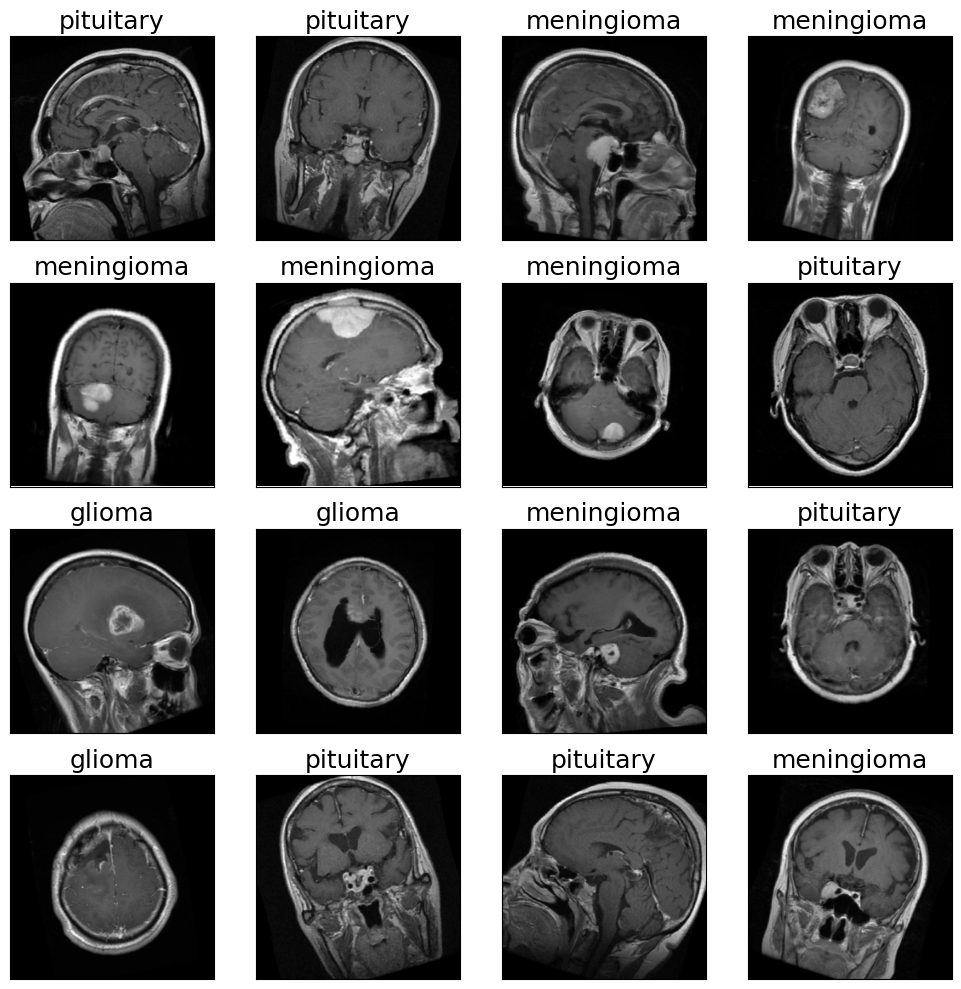

In [ ]:
# Visualize Data

data_iter=iter(train_loader)
images,labels=next(data_iter)

images=images.numpy()

iteration=16

fig=plt.figure(figsize=(10,10))

for index in np.arange(iteration):

    ax=fig.add_subplot(4,int(iteration/4),index+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(images[index]),cmap="gray")
    #do not know why labels do not work
    ax.set_title("meningioma" if str(labels[index])[-2] == "2" else "glioma" if str(labels[index])[-2] == "1" else "pituitary" if str(labels[index])[-2] == "3" else "noclass", fontsize=18)



plt.tight_layout()

In [ ]:
class VGG16(nn.Module):

    def __init__(self,num_classes=1000):
        super(VGG16,self).__init__()

        #feature extractor
        self.features=nn.Sequential(
            #grayscale image -> 64 feature maps
            nn.Conv2d(1,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #64 feature maps -> 128
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #128 -> 256
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #256 -> 512
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),

            #512 -> 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )

        #resizes self.features into 7x7
        self.avgpool=nn.AdaptiveAvgPool2d((7,7))

        #extracts features
        self.classifier=nn.Sequential(nn.Linear(512*7*7,4096),
                                     nn.ReLU(inplace=True),
                                     nn.Dropout(),
                                     nn.Linear(4096,4096),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(4096,num_classes)
                                     )

        self._initialize_weights()


    def forward(self,x):
        x=self.features(x)          # Feature extraction
        x=self.avgpool(x)           # Resize to (7, 7)
        x = x.view(x.size(0), -1)   # Flatten to a vector
        x=self.classifier(x)        # Fully connected layers

        return x


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)

##Train Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

vgg16_kaiming = VGG16(num_classes=4).to(device)

epochs = 40
learning_rate = 1e-4

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(vgg16_kaiming.parameters(), lr=learning_rate)

def train(model,train_loader,optimizer,criteron):
    model.train()
    train_loss=0
    correct=0
    total=0

    for images,labels in train_loader:
        images,labels =images.to(device),labels.to(device)

        optimizer.zero_grad()
        outputs=model(images)
        loss=criterion(outputs,labels)

        loss.backward()
        optimizer.step()

        train_loss+=loss.item()
        _,predicted=outputs.max(1)
        total+=labels.size(0)
        correct+=predicted.eq(labels).sum().item()

    train_accuracy=100*correct/total
    train_loss/=len(train_loader)
    return train_loss,train_accuracy

def validate(model,valid_loader,criterion):
    model.eval()
    val_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for images,labels in valid_loader:
            images,labels=images.to(device),labels.to(device)

            outputs=model(images)
            loss=criterion(outputs,labels)

            val_loss+=loss.item()
            _,predicted=outputs.max(1)
            total+=labels.size(0)
            correct+=predicted.eq(labels).sum().item()

        val_accuracy = 100.0 * correct / total
        val_loss /= len(valid_loader)
    return val_loss, val_accuracy

cuda:0


In [ ]:
train_accuracy = []
validation_accuracy = []
train_losses = []
validation_losses = []

patience = 5                  # Number of epochs to wait before stopping
best_val_loss = float('inf')  # Initialize with infinity
counter = 0                   # Counter for how many epochs since last improvement

for epoch in range(epochs):
    train_loss, train_acc = train(vgg16_kaiming, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(vgg16_kaiming, valid_loader, criterion)

    train_accuracy.append(train_acc)
    validation_accuracy.append(val_acc)
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f} Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0  # Reset the counter when improvement occurs
    else:
        counter += 1
        print(f"Early stopping counter: {counter}/{patience}")

        if counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

Epoch 1/40: Train Loss: 1.0946, Validation Loss: 0.9391 Train Accuracy: 39.14%, Validation Accuracy: 66.71%
Epoch 2/40: Train Loss: 0.7275, Validation Loss: 0.5800 Train Accuracy: 66.58%, Validation Accuracy: 77.06%
Epoch 3/40: Train Loss: 0.5412, Validation Loss: 0.5962 Train Accuracy: 76.79%, Validation Accuracy: 72.55%
Early stopping counter: 1/5
Epoch 4/40: Train Loss: 0.4546, Validation Loss: 0.4183 Train Accuracy: 81.23%, Validation Accuracy: 84.35%
Epoch 5/40: Train Loss: 0.3637, Validation Loss: 0.3363 Train Accuracy: 85.41%, Validation Accuracy: 87.00%
Epoch 6/40: Train Loss: 0.2994, Validation Loss: 0.2956 Train Accuracy: 87.43%, Validation Accuracy: 86.87%
Epoch 7/40: Train Loss: 0.2459, Validation Loss: 0.2503 Train Accuracy: 90.02%, Validation Accuracy: 90.19%
Epoch 8/40: Train Loss: 0.1799, Validation Loss: 0.2785 Train Accuracy: 92.49%, Validation Accuracy: 89.79%
Early stopping counter: 1/5
Epoch 9/40: Train Loss: 0.1391, Validation Loss: 0.2227 Train Accuracy: 95.25%, 

##Training Results

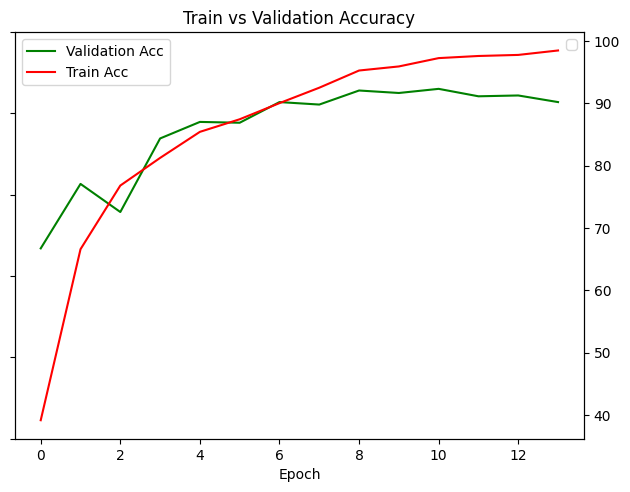

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(np.array(validation_accuracy),label = "Validation Acc",color="green")
ax2.plot(np.array(train_accuracy),label = "Train Acc",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])
fig.tight_layout()
plt.title("Train vs Validation Accuracy")
plt.show()

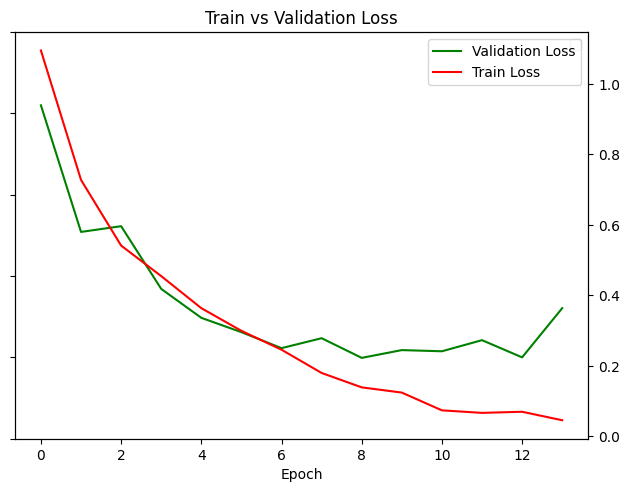

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.plot(np.array(validation_losses),label = "Validation Loss",color="green")
ax2.plot(np.array(train_losses),label = "Train Loss",color= "red")
ax1.legend()
ax2.legend()
ax1.set_xlabel('Epoch')
ax1.set_yticklabels([])
fig.tight_layout()
plt.title("Train vs Validation Loss")
plt.show()

In [ ]:
predictions=[]
actual_labels=[]

vgg16_kaiming.eval()

with torch.no_grad():
    for images,labels in tumor_detected_loader:
        images = images.to(device)
        labels = labels.to(device)


        outputs=vgg16_kaiming(images)

        _,predicted=torch.max(outputs,1)

        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

results_df=pd.DataFrame({"Actual":actual_labels,"Predicted":predictions})
results_df

,Actual,Predicted
0,2,2
1,1,1
2,1,2
3,2,2
4,1,2
...,...,...
841,2,1
842,2,2
843,2,2
844,2,2


In [ ]:
from sklearn.metrics import accuracy_score

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

accuracy=accuracy_score(true_labels,predicted_labels)

correct_predictions = (true_labels == predicted_labels).sum()
print(f"Total number of correct predictions: {correct_predictions}")
print(f"Accuracy Score:% {accuracy*100}")

Total number of correct predictions: 663
Accuracy Score:% 78.36879432624113


<Axes: >

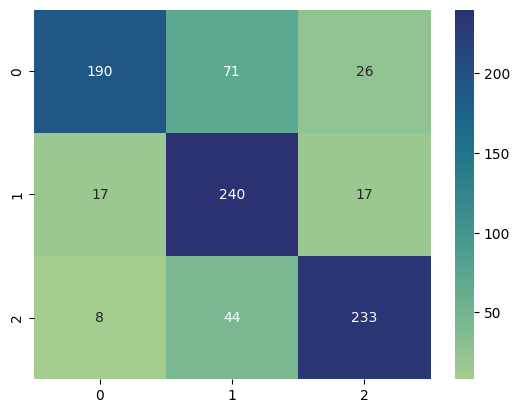

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_labels=results_df["Actual"]
predicted_labels=results_df["Predicted"]

confusionMatrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(confusionMatrix, annot=True, cmap='crest', fmt='g')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           1       0.88      0.66      0.76       287
           2       0.68      0.88      0.76       274
           3       0.84      0.82      0.83       285

    accuracy                           0.78       846
   macro avg       0.80      0.79      0.78       846
weighted avg       0.80      0.78      0.78       846

